In [2]:
import numpy as np
import pandas as pd
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import os
from nilearn import plotting
from nilearn import image
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.first_level import make_first_level_design_matrix


In [3]:
import warnings

from nilearn.image import concat_imgs, mean_img, resample_img

# Avoid getting too many warnings due to resampling
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    four_runs = [
        concat_imgs(os.path.join('func', f'run0{run}', '*.nii'), auto_resample=True) for run in np.arange(4) + 1
    ]
affine, shape = four_runs[0].affine, four_runs[0].shape

four_runs[1] = resample_img(
    four_runs[1], affine, shape[:3],force_resample=True
)
total_scan_time = 330
tr = 2.0 
n_scans = 171
frame_times = np.arange(n_scans) * tr
hrf_model = "spm + derivative"
high_pass = 0.01
tr = 2.0 
design_matrices = []
for run in np.arange(4) + 1:

    pattern = os.path.join('func', f'run0{run}', '*.nii')
    nii_files = glob.glob(pattern)
    n_scans = image.load_img(nii_files).shape[-1] #number of scans per acquisition
    frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times
    tsv_file = pd.read_csv(f'func/run0{run}/events.tsv', sep='\t')
    events = tsv_file[['onset', 'duration']]
    design_mat = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        high_pass=high_pass
    )
    design_matrices.append(design_mat)

/usr/local/python/3.12.1/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(


In [4]:
first_level_model = FirstLevelModel(
    t_r=tr,
    hrf_model=hrf_model,
    high_pass=high_pass,
    smoothing_fwhm=6.0,
    minimize_memory=False
)

fitted_models = []
for i, (run_img, design_matrix) in enumerate(zip(four_runs, design_matrices)):
    print(f"Fitting model for run {i + 1}")
    model = first_level_model.fit(run_img, design_matrices=design_matrix)
    fitted_models.append(model)


Fitting model for run 1
Fitting model for run 2
Fitting model for run 3
Fitting model for run 4


In [5]:
contrast_matrix = np.eye(design_matrices[0].shape[1]) 
task_contrast = contrast_matrix[0] 

z_maps = []
for i, model in enumerate(fitted_models):
    print(f"Computing contrast for run {i + 1}")
    z_map = model.compute_contrast(task_contrast, output_type='z_score')
    z_maps.append(z_map)


Computing contrast for run 1
Computing contrast for run 2
Computing contrast for run 3
Computing contrast for run 4


Plotting Z map for run 1


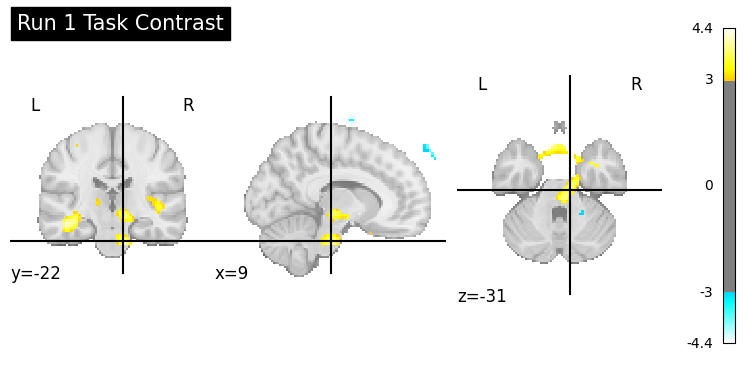

Plotting Z map for run 2


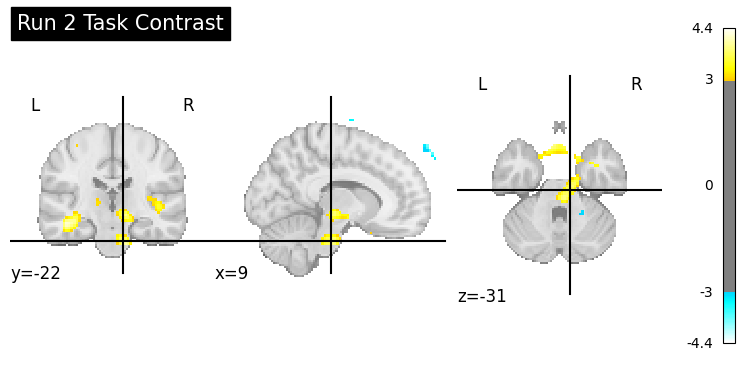

Plotting Z map for run 3


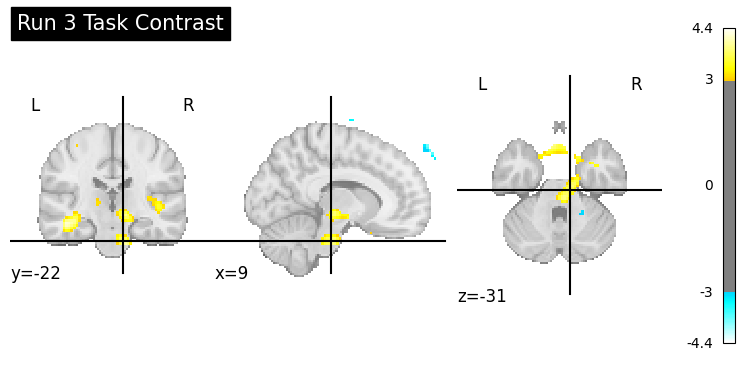

Plotting Z map for run 4


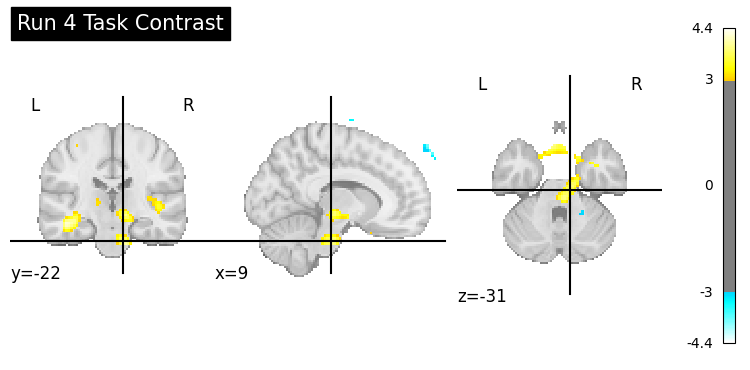

In [6]:
# Visualize each z-map for the contrast
for i, z_map in enumerate(z_maps):
    print(f"Plotting Z map for run {i + 1}")
    display = plot_stat_map(z_map, title=f"Run {i + 1} Task Contrast", threshold=3.0, display_mode='ortho')
    plt.show()


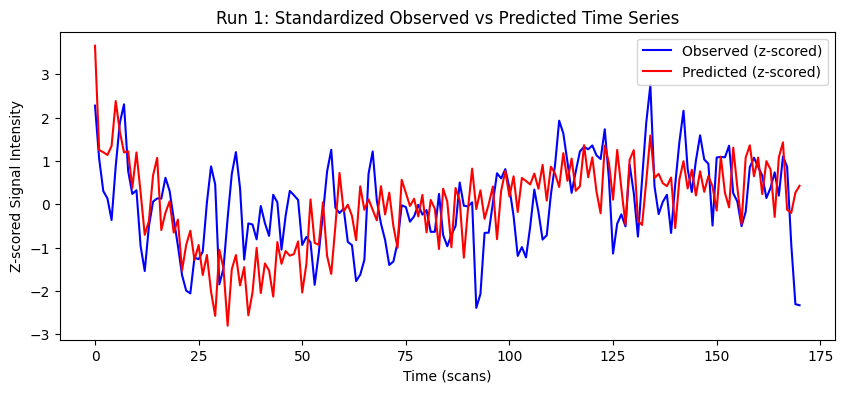

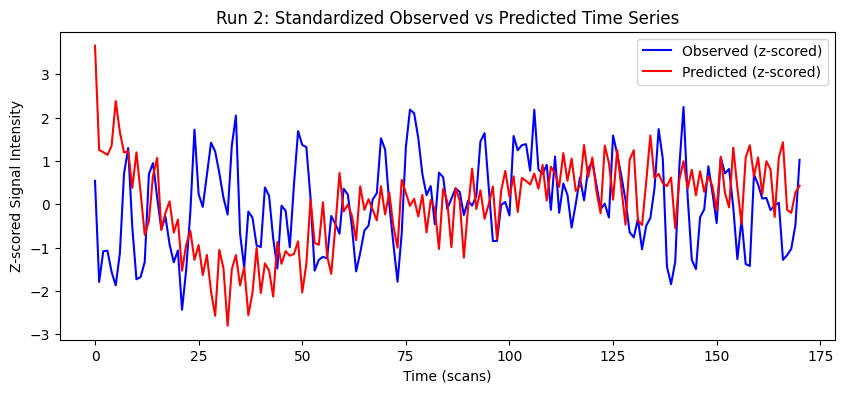

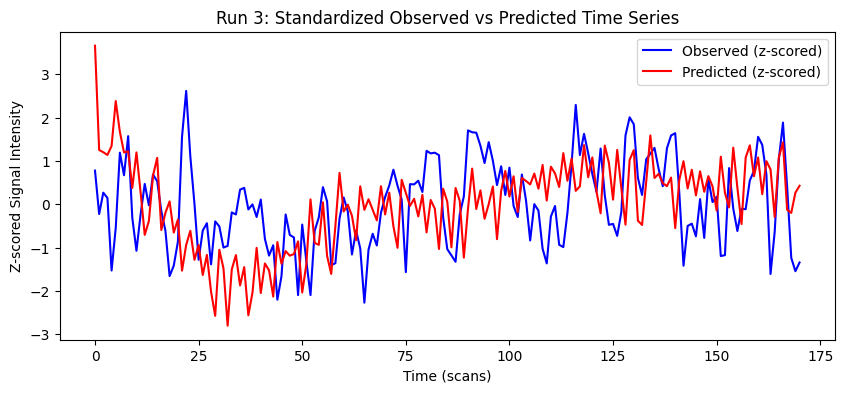

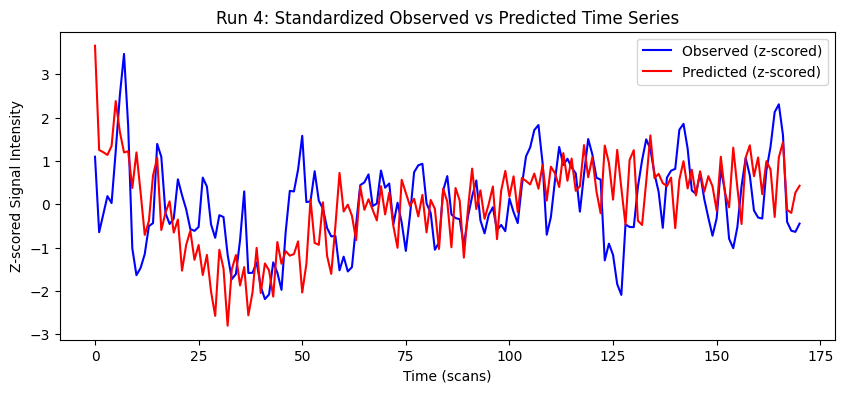

In [ ]:
from sklearn.preprocessing import StandardScaler
from nilearn.maskers import NiftiSpheresMasker

roi_coords = [(30, -10, 50)]
masker = NiftiSpheresMasker(roi_coords, radius=8, t_r=tr)

for i, model in enumerate(fitted_models):

    observed_timeseries = masker.fit_transform(four_runs[i])
    predicted_timeseries = masker.fit_transform(model.predicted[0]) 
    
    scaler = StandardScaler()
    observed_scaled = scaler.fit_transform(observed_timeseries)
    predicted_scaled = scaler.fit_transform(predicted_timeseries)

    plt.figure(figsize=(10, 4))
    plt.plot(observed_scaled, label='Observed (z-scored)', color='blue')
    plt.plot(predicted_scaled, label='Predicted (z-scored)', color='red')
    plt.legend()
    plt.title(f"Run {i + 1}: Standardized Observed vs Predicted Time Series")
    plt.xlabel("Time (scans)")
    plt.ylabel("Z-scored Signal Intensity")
    plt.show()
